In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const
from astropy.time import Time
from astropy.coordinates import (
    SkyCoord, SkyOffsetFrame, EarthLocation, CartesianRepresentation,
    CylindricalRepresentation, UnitSphericalRepresentation
)

from screens.screen import Source, Screen1D, Telescope
from screens.fields import phasor

In [2]:
def axis_extent(x):
    x = x.ravel().value
    dx = x[1]-x[0]
    return x[0]-0.5*dx, x[-1]+0.5*dx

In [3]:
xyz2yzx = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
])

In [4]:
d_p = 0.620 * u.kpc

psr_coord = SkyCoord('08h37m5.644606s +06d10m15.4047s',
                     distance=d_p,
                     pm_ra_cosdec=2.16 * u.mas / u.yr,
                     pm_dec=51.64 * u.mas / u.yr)

psr_frame = SkyOffsetFrame(origin=psr_coord)

In [5]:
vel_psr = (psr_coord
           .transform_to(psr_frame)
           .velocity
           .to_cartesian()
           .transform(xyz2yzx))

In [6]:
pulsar = Source(vel=vel_psr)

In [7]:
tel_loc = EarthLocation('66°45′10″W', '18°20′48″N')

t_obs = Time(53712.29719907, format='mjd', scale='tai')

vel_tel = (tel_loc
           .get_gcrs(t_obs)
           .transform_to(psr_frame)
           .velocity
           .to_cartesian()
           .transform(xyz2yzx))

In [8]:
telescope = Telescope(vel=vel_tel)

In [9]:
d_s1 = 0.389 * u.kpc
xi1 = 154.8 * u.deg
v_lens1 = 23.1 * u.km / u.s

In [10]:
fd1 = [
    -15.93, -15.05, -14.47, -13.59, -13.00, -12.41, -11.83,  -9.78,
     -8.31,  -5.38,  -3.62,  -2.15,  -1.27,  -0.10,   1.08,   1.96,
      4.59,   5.47,   7.53,   9.29,  10.46,  15.15,
] * u.mHz

In [11]:
lens1_frame = SkyOffsetFrame(origin=psr_coord, rotation=xi1)

v_psr1 = psr_coord.transform_to(lens1_frame).velocity.d_z

v_tel1 = (tel_loc
          .get_gcrs(t_obs)
          .transform_to(lens1_frame)
          .velocity
          .d_z)

In [12]:
s1 = 1. - d_s1 / d_p
v_eff1 = 1. / s1 * v_lens1 - (1. - s1) / s1 * v_psr1 - v_tel1

In [13]:
f_obs = 318.5 * u.MHz
lambda_obs = const.c / f_obs

theta1 = (lambda_obs * fd1 / v_eff1
         ).to(u.mas, equivalencies=u.dimensionless_angles())

pos1 = (theta1 * d_s1).to(u.au, equivalencies=u.dimensionless_angles())

In [14]:
d_eff1 = (1. - s1) / s1 * d_p

eta1 = lambda_obs**2 * d_eff1 / (2. * const.c * v_eff1**2)

eta1.to(u.s**3)

<Quantity 0.6039635 s3>

In [15]:
brightness1 = [
      1.20,  1.66,  1.60,  1.45,  1.37,  0.99,  1.22,  8.99,
      8.51,  6.48, 22.04, 26.32, 28.05, 27.78, 22.64, 21.20,
     40.38, 18.76, 10.80,  6.31,  5.02,  0.21,
] * u.dimensionless_unscaled

rng = np.random.default_rng(seed=12345)
phase1 = rng.random(len(brightness1)) * 2.*np.pi

magnification1 = brightness1 / brightness1.max() * np.exp(1j*phase1)

In [16]:
normal1 = CylindricalRepresentation(1., 90.*u.deg - xi1, 0.).to_cartesian()

screen1 = Screen1D(normal=normal1,
                   p=pos1,
                   v=v_lens1,
                   magnification=magnification1)

In [17]:
d_s2 = 0.415 * u.kpc
xi2 =  46.1 * u.deg
v_lens2 = -3.3 * u.km / u.s

In [18]:
pos2 = [9.1652957] * u.au
magnification2 = 0.1

In [19]:
normal2 = CylindricalRepresentation(1., 90.*u.deg - xi2, 0.).to_cartesian()

screen2 = Screen1D(normal=normal2,
                   p=pos2,
                   v=v_lens2,
                   magnification=magnification2)

In [20]:
obs1 = telescope.observe(
    source=screen1.observe(source=pulsar, distance=d_p-d_s1),
    distance=d_s1)

obs2 = telescope.observe(
    source=screen1.observe(
        source=screen2.observe(source=pulsar, distance=d_p-d_s2),
        distance=d_s2-d_s1),
    distance=d_s1)

In [21]:
obs2.tau
bool_on_lens2 = obs2.source.pos.x.ravel() < 7. * u.au

In [22]:
tau0 = np.hstack([obs1.tau.ravel(),
                  obs2.tau.ravel()[bool_on_lens2]])
taudot = np.hstack([obs1.taudot.ravel(),
                    obs2.taudot.ravel()[bool_on_lens2]])
brightness = np.hstack([obs1.brightness.ravel(),
                        obs2.brightness.ravel()[bool_on_lens2]])

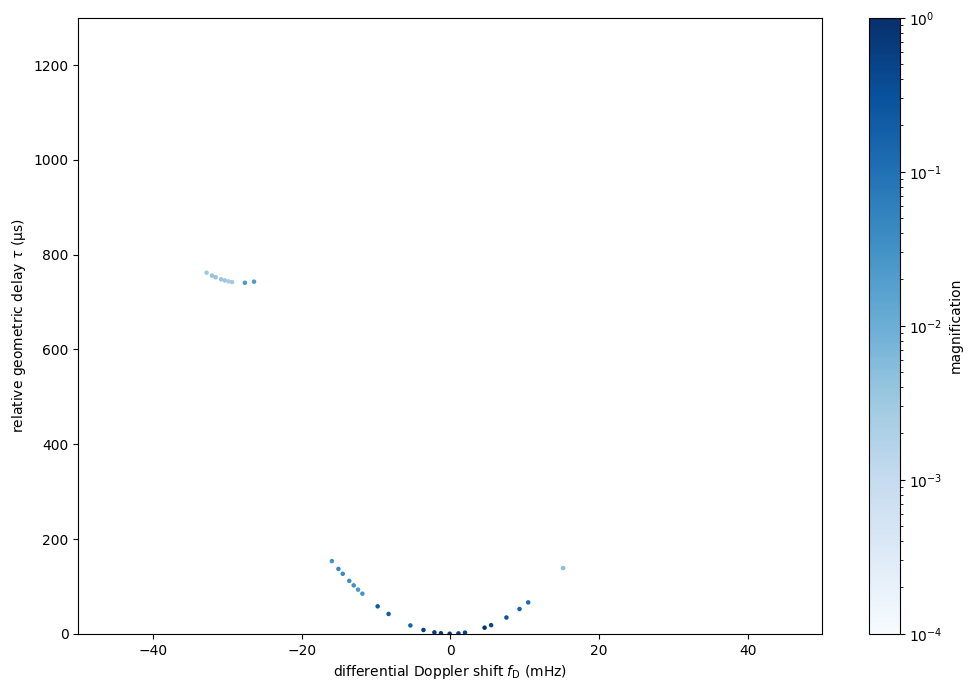

In [23]:
fd_all = f_obs * taudot

plt.figure(figsize=(12., 8.))

plt.scatter(fd_all.to(u.mHz), tau0.to(u.us),
            c=np.abs(brightness).value, s=5, cmap='Blues',
            norm=LogNorm(vmin=1.e-4, vmax=1.))

plt.xlim(-50., 50.)
plt.ylim(0., 1300.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ (mHz)")
plt.ylabel(r"relative geometric delay $\tau$ ($\mathrm{\mu s}$)")

cbar = plt.colorbar()
cbar.set_label('magnification')

plt.show()

In [24]:
t = np.linspace(0, 45*u.min, 300)[:, np.newaxis]
f = np.linspace(318.*u.MHz, 319.*u.MHz, 3000)

In [25]:
tau_t = (tau0[:, np.newaxis, np.newaxis]
        + taudot[:, np.newaxis, np.newaxis] * t)

ph = phasor(f, tau_t)

dynwave = ph * brightness[:, np.newaxis, np.newaxis]

dynspec = np.abs(dynwave.sum(0))**2

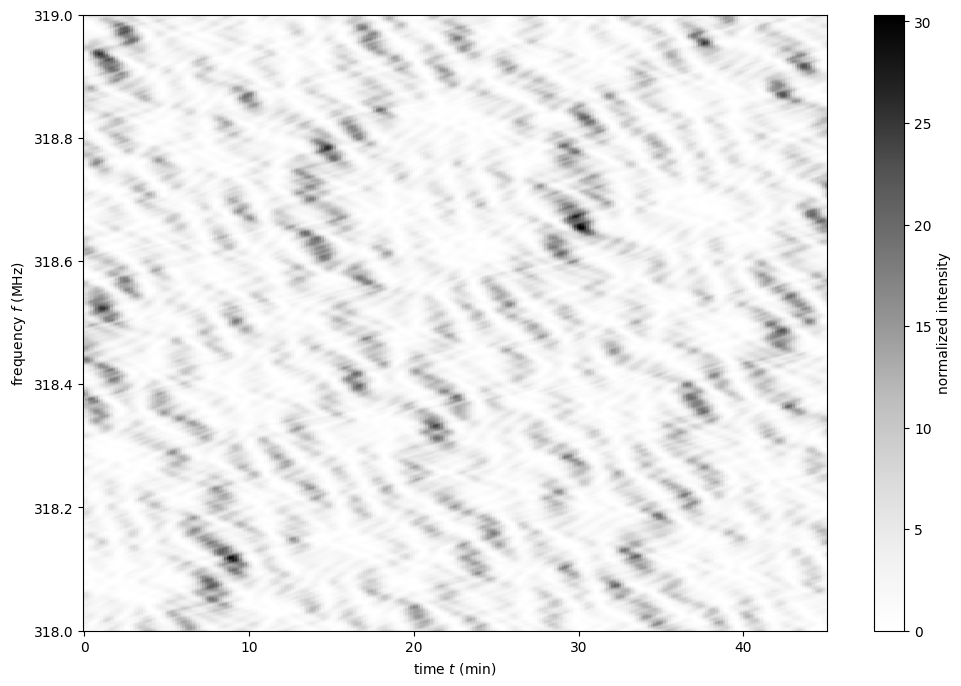

In [26]:
plt.figure(figsize=(12., 8.))

plt.imshow(dynspec.T,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(t) + axis_extent(f), vmin=0.)
plt.xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
plt.ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized intensity')

In [27]:
conjspec = np.fft.fft2(dynspec)
conjspec /= conjspec[0, 0]
conjspec = np.fft.fftshift(conjspec)

tau = np.fft.fftshift(np.fft.fftfreq(f.size, f[1]-f[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq(t.size, t[1]-t[0])).to(u.mHz)

secspec = np.abs(conjspec)**2

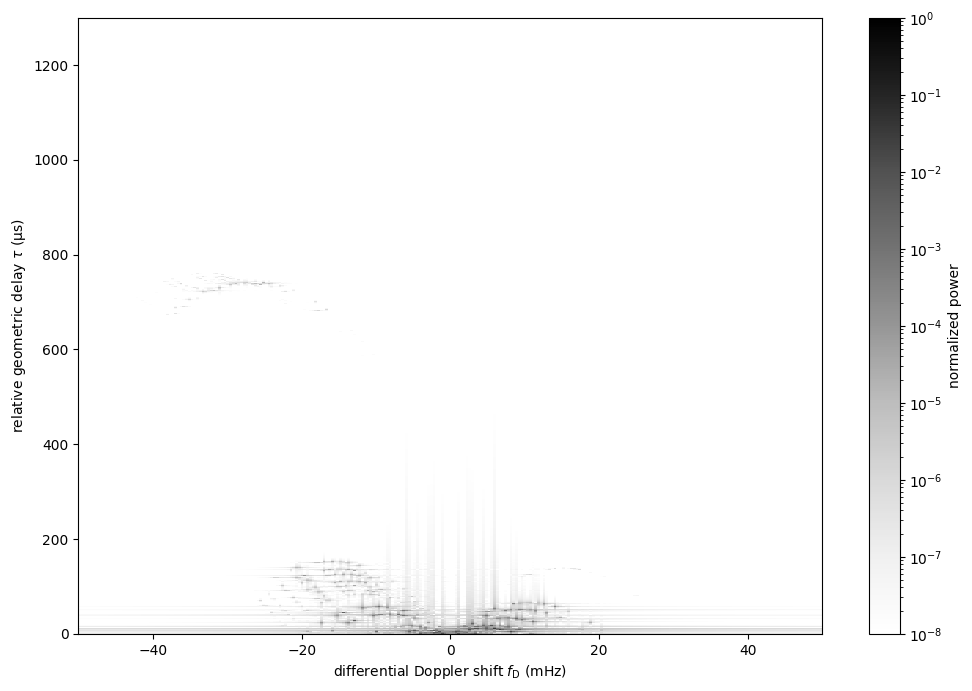

In [28]:
plt.figure(figsize=(12., 8.))

plt.imshow(secspec.T.value,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(fd) + axis_extent(tau),
           norm=LogNorm(vmin=1.e-8, vmax=1.))

plt.xlim(-50., 50.)
plt.ylim(0., 1300.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.show()

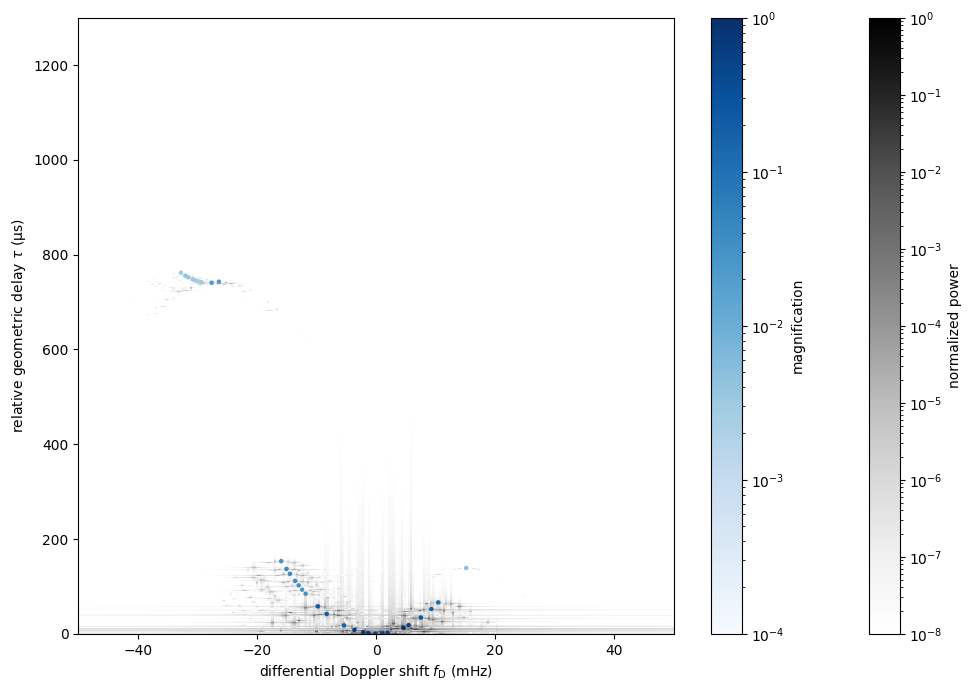

In [29]:
plt.figure(figsize=(12., 8.))

plt.imshow(secspec.T.value,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(fd) + axis_extent(tau),
           norm=LogNorm(vmin=1.e-8, vmax=1.))

plt.xlim(-50., 50.)
plt.ylim(0., 1300.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.scatter(fd_all.to(u.mHz), tau0.to(u.us),
            c=np.abs(brightness).value, s=5, cmap='Blues',
            norm=LogNorm(vmin=1.e-4, vmax=1.))

cbar = plt.colorbar()
cbar.set_label('magnification')

plt.show()